In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Учеба/'Семестр № 3'/'Анализ защищенности систем искусственного интеллекта'/prz5

Mounted at /content/drive
/content/drive/MyDrive/Учеба/Семестр № 3/Анализ защищенности систем искусственного интеллекта/prz5


In [1]:
!git clone https://github.com/marcotcr/lime.git

Cloning into 'lime'...
remote: Enumerating objects: 2389, done.
remote: Total 2389 (delta 0), reused 0 (delta 0), pack-reused 2389
Receiving objects: 100% (2389/2389), 21.41 MiB | 11.41 MiB/s, done.
Resolving deltas: 100% (1600/1600), done.


In [2]:
!pip install ./lime/

Processing ./lime
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=284256 sha256=409a3b008c1449052c92becc9fdda95dfcc0dc38c9dedfe007ab39d29cfb23f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ti4ge5b/wheels/70/07/d9/357d462be353e851c7216f0a622b8e1a7f4b10d0f1e2e8a5b3
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25520 sha256=67242e20525faef525b359af4548d70e2124490f299f819599a472130e894eb5
  Stored in directory: /root/.cache/pip/wheels/46/1f/29/6fda5c72f950841e39147ae603780ee913a62f977b4ad47ee4
Successfully built lime pyDOE2


# Overview
The notebook shows how the ```lime_image``` tools can be applied to a smaller dataset like mnist. The dataset is very low resolution and allows quite a bit of rapid-iteration.

In [3]:
# Знакомство с работой интерпритатора моделей машинного обучения при помощи lime
# Импортируем библиотеки
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
%matplotlib inline

In [4]:
# Загружаем набор данных mnist
X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)
y_vec = y.astype(np.uint8)

Для корректной работы lime, необходимо преобразовать стандартное представление цифр в MNIST в RGB формат, а именно Ч/Б

Text(0.5, 1.0, 'Digit: 5')

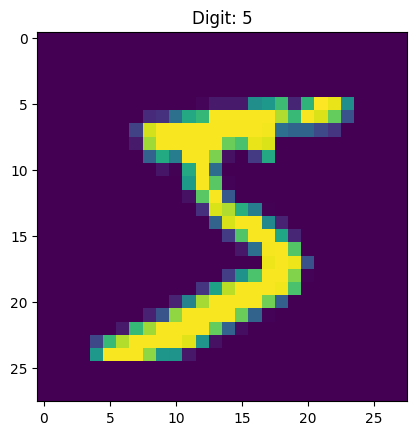

In [ ]:
X_vec = X.reshape((-1, 28, 28)).astype(np.uint8)
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

Text(0.5, 1.0, 'Digit: 5')

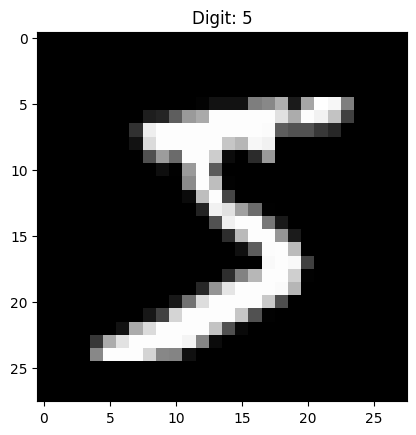

In [5]:
X_vec = np.stack([gray2rgb(iimg) for iimg in X.reshape((-1, 28, 28))],0).astype(np.uint8)
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

# Setup a Pipeline
Анализ решений модели на основе интерпритации LIME

In [6]:
# Создаем простой конвеер, в котором будут последовательно вызываться функции предобработки и обучения модели
class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [7]:
# Разделяем данные
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.55)

In [8]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7c28d37db850>),
                ('Flatten Image', <__main__.PipeStep object at 0x7c28d37db7f0>),
                ('RF', RandomForestClassifier())])

In [9]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

In [10]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [11]:
# Вариант 18
index = 18
# Инициализируем модель интерпритации LIME для X_test[Вариант]
explanation = explainer.explain_instance(X_test[index],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Positive/Negative Regions for 2')

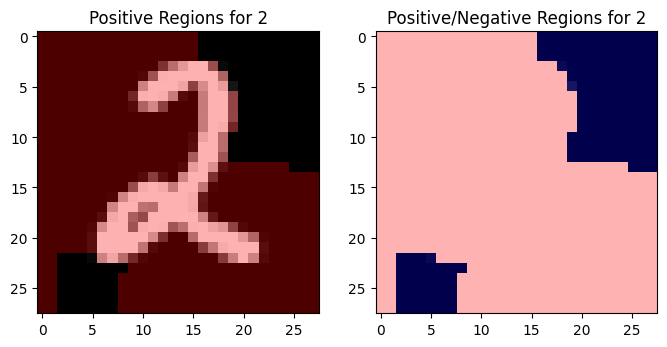

In [12]:
temp, mask = explanation.get_image_and_mask(y_test[index], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[index]))
temp, mask = explanation.get_image_and_mask(y_test[index], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[index]))

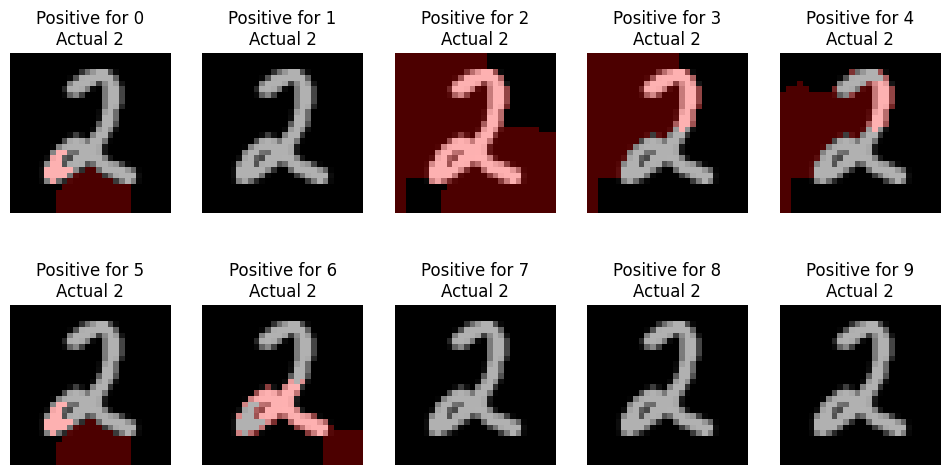

In [13]:
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[index], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[index]))
    c_ax.axis('off')

# Видно, что область определения цифры как 2 гораздо больше чем все остальные (хоть и близка, например, к 3), поэтому модель верно определила цифру.

# Gaining Insight
А теперь посмотрим, почему модель ошиблась

In [ ]:
pipe_pred_test = simple_rf_pipeline.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #29823 where the label was 9 and the pipeline predicted 4


In [ ]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 8.35 s, sys: 191 ms, total: 8.54 s
Wall time: 8.84 s


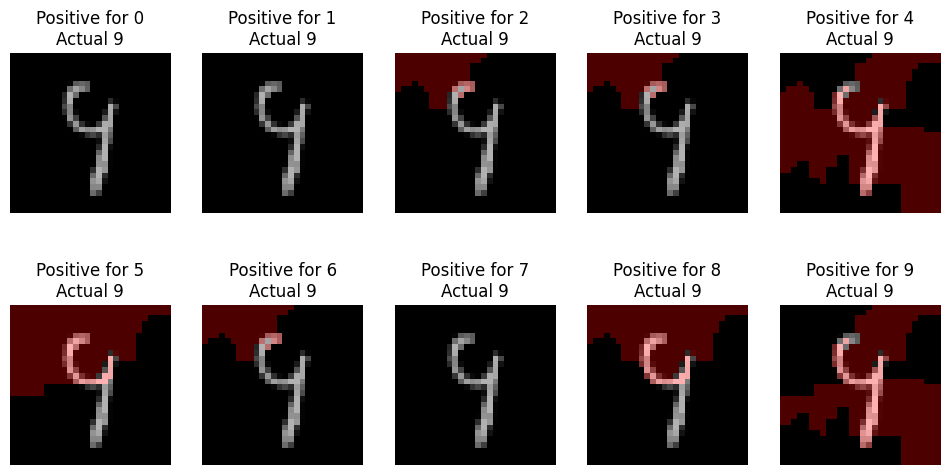

In [ ]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')

#Видно, что область, отвечающая за определение числа 9 как 9 почти совпадает с областью, которая служит для определения числа 9 как 4, именно поэтому модель ошиблась. Помиомо этого область 4 больше чем 9.
#Из данного примеры мы также видим, что маска, которая служит областью для определения числа как 9 занимает почти все пространство числа, кроме его верхней левой части. При этом маска определения числа как 2 или 3 - это как раз та часть, которая не нужна для определения как 9. Следовательно, если мы уберем область подсвеченную красным для правильного определения, модель определит число как 2 или 3.